In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
def plt_show_color(image):
    b, g, r = cv2.split(image)
    img = cv2.merge([r,g,b])
    plt.imshow(img)
    plt.show()
def plt_show_gray(image):
    plt.imshow(image, cmap='gray')
    plt.show()

In [2]:
def color_position(image):
    colors = [
        # ([26, 43, 46], [34, 255, 255]),  # 黄色
        ([100, 100, 50], [124, 255, 255]),  # 蓝色
        # ([35, 43, 46], [77, 255, 255])   # 绿色
    ]
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    for (lower, upper) in colors:
        lower = np.array(lower, dtype="uint8")  # 颜色下限
        upper = np.array(upper, dtype="uint8")  # 颜色上限

        # 根据阈值找到相应的颜色
        mask = cv2.inRange(hsv, lowerb=lower, upperb=upper)
        output = cv2.bitwise_and(image, image, mask=mask)
        # cv2.imshow("image", img)
        # cv2.imshow("image_color", output)
        # cv2.waitKey(0)
    return output

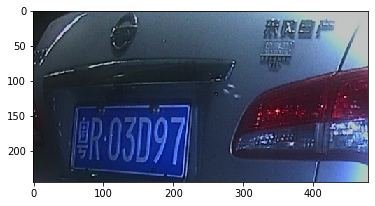

In [3]:
# 图像显示
src = cv2.imread('15313096344_2.jpg')
plt_show_color(src)

In [4]:
sp = src.shape
print(sp[0])
print(sp[1])

245
479


In [5]:
def unevenLightCompensate(img, blockSize):# 光照均衡化，过度地带颜色偏深
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    average = np.mean(gray)

    rows_new = int(np.ceil(gray.shape[0] / blockSize))
    cols_new = int(np.ceil(gray.shape[1] / blockSize))

    blockImage = np.zeros((rows_new, cols_new), dtype=np.float32)
    for r in range(rows_new):
        for c in range(cols_new):
            rowmin = r * blockSize
            rowmax = (r + 1) * blockSize
            if (rowmax > gray.shape[0]):
                rowmax = gray.shape[0]
            colmin = c * blockSize
            colmax = (c + 1) * blockSize
            if (colmax > gray.shape[1]):
                colmax = gray.shape[1]

            imageROI = gray[rowmin:rowmax, colmin:colmax]
            temaver = np.mean(imageROI)
            blockImage[r, c] = temaver

    blockImage = blockImage - average
    blockImage2 = cv2.resize(blockImage, (gray.shape[1], gray.shape[0]), interpolation=cv2.INTER_CUBIC)
    gray2 = gray.astype(np.float32)
    dst = gray2 - blockImage2
    dst = dst.astype(np.uint8)
    dst = cv2.GaussianBlur(dst, (3, 3), 0)

    return dst

In [6]:
# blockSize = 16
# image = unevenLightCompensate(Gauss, blockSize)
# plt_show_gray(image)

In [7]:
# def unevenLightCompensate(img, blockSize):# 光照均衡化，过度地带颜色偏深
#     gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#     average = np.mean(gray)

#     rows_new = int(np.ceil(gray.shape[0] / blockSize))
#     cols_new = int(np.ceil(gray.shape[1] / blockSize))

#     blockImage = np.zeros((rows_new, cols_new), dtype=np.float32)
#     for r in range(rows_new):
#         for c in range(cols_new):
#             rowmin = r * blockSize
#             rowmax = (r + 1) * blockSize
#             if (rowmax > gray.shape[0]):
#                 rowmax = gray.shape[0]
#             colmin = c * blockSize
#             colmax = (c + 1) * blockSize
#             if (colmax > gray.shape[1]):
#                 colmax = gray.shape[1]

#             imageROI = gray[rowmin:rowmax, colmin:colmax]
#             temaver = np.mean(imageROI)
#             blockImage[r, c] = temaver

#     blockImage = blockImage - average
#     blockImage2 = cv2.resize(blockImage, (gray.shape[1], gray.shape[0]), interpolation=cv2.INTER_CUBIC)
#     gray2 = gray.astype(np.float32)
#     dst = gray2 - blockImage2
#     dst = dst.astype(np.uint8)
#     dst = cv2.GaussianBlur(dst, (3, 3), 0)

#     return dst
# blockSize = 16
# src = unevenLightCompensate(src, blockSize)
# cv2.imshow("123", src)
# cv2.waitKey()

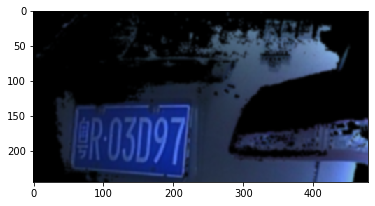

In [8]:
# 首先颜色过滤掉白色的字，然后进行高斯模糊
src2 = src.copy()
# src2 = src2[int(sp[0]/10):int(sp[0]*4/5):, :int(sp[1]*2/5)]
src2 = color_position(src2)
Gauss = cv2.GaussianBlur(src2, (7, 7), 0)
plt_show_color(Gauss)

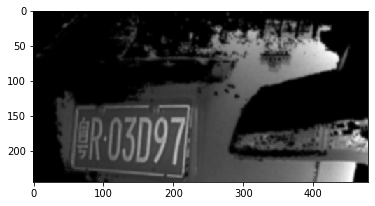

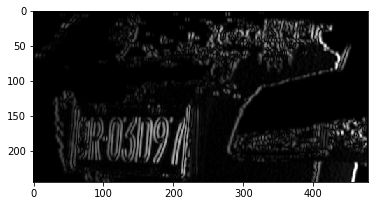

In [9]:
# 转换为灰度图
gray = cv2.cvtColor(Gauss, cv2.COLOR_BGR2GRAY)
plt_show_gray(gray)
# sobel算子边缘检测
Sobel_x = cv2.Sobel(gray, cv2.CV_16S, 1, 0)
absX = cv2.convertScaleAbs(Sobel_x)
image = absX.copy()
plt_show_gray(image)
# img = cv2.Canny(gray, 100, 100)
# plt_show_gray(img)


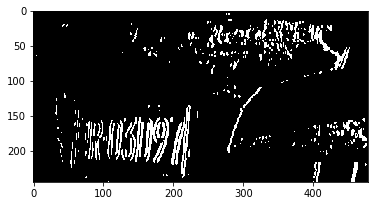

In [10]:
# 转化为二值图象，以用于findcontours
ret, binary = cv2.threshold(image, 60, 255, cv2.THRESH_BINARY)
plt_show_gray(binary)

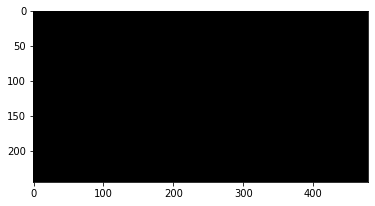

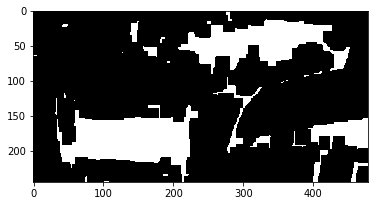

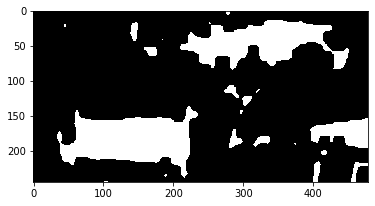

In [11]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (7, 7))  # 定义结构元素
kerne2 = cv2.getStructuringElement(cv2.MORPH_RECT, (15, 15))
opening = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)  # 开运算
closing = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kerne2)
# opening = cv2.morphologyEx(closing, cv2.MORPH_OPEN, kernel)
plt_show_gray(opening)
plt_show_gray(closing)
dst = cv2.medianBlur(closing, 7)
plt_show_gray(dst)

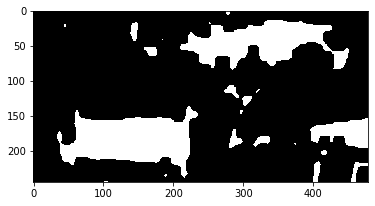

In [12]:
# 去除小的白点来创建的
kernelX = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 1))
# kernelY = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 11))
# 膨胀，腐蚀
image = cv2.dilate(dst, kernelX)
image = cv2.erode(image, kernelX)
# # 腐蚀，膨胀
# image = cv2.erode(image, kernelY)
# image = cv2.dilate(image, kernelY)
plt_show_gray(image)

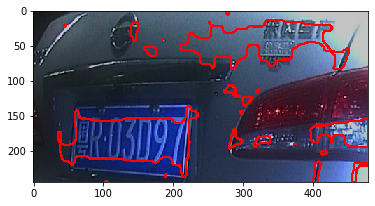

In [13]:
# 轮廓检测
# cv2.RETR_EXTERNAL表示只检测外轮廓
# cv2.CHAIN_APPROX_SIMPLE压缩水平方向，垂直方向，对角线方向的元素， 只保留该方向的终点坐标，
# 例如一个矩形轮廓只需要四个点来保存轮廓信息
contours, hierarchy = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# 绘制轮廓
imagel = src.copy()
cv2.drawContours(imagel, contours, -1, (0, 0, 255), 2)
plt_show_color(imagel)

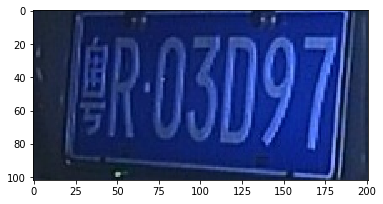

In [14]:
s = []
for item in contours:
    # cv2.boundingRect用一个最小的矩形，把新形状包起来
    rect = cv2.boundingRect(item)
    x = rect[0]
    y = rect[1]
    weight = rect[2]
    height = rect[3]
    if (weight > (height * 1.2)) and (weight < (height * 6)):
        s.append(weight * height)
for item in contours:
    # cv2.boundingRect用一个最小的矩形，把新形状包起来
    rect = cv2.boundingRect(item)
    x = rect[0]
    y = rect[1]
    weight = rect[2]
    height = rect[3]
    if (weight > (height * 1.2)) and (weight < (height * 6)) and weight*height==max(s):
        image = src[y:y + height, x:x + weight]
        plt_show_color(image)
        cv2.imwrite("111222333.jpg",image)
        break